
# Auto Decision Tree Workbench (with Unicode helpers)

This notebook trains a Decision Tree on **any CSV** following this naming scheme:

- `xxx_predictors1, xxx_predictors2, ...` (optional meta columns; not used directly by the model)
- `xxx_feature1_1, xxx_feature1_2, xxx_feature2_1, xxx_feature2_2, ...` (input features)
- `xxx_targets1, xxx_targets2, ...` (one or more targets — can be numeric or categorical)

**What's new**
- **Unicode translation option**: If your data contains non-English characters, you can translate strings to **Unicode code points** right after loading the CSV.
- **Unicode-aware prediction helper**: An interactive cell that converts what you type into Unicode codes before prediction, and also prints the prediction again as Unicode codes (for string outputs).


In [16]:

import re
import json
import joblib
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, f1_score, accuracy_score, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# --- User settings ---
DATA_PATH = 'book1.csv'   # <- change to your CSV path
TEST_SIZE = 0.2
RANDOM_STATE = 42
MAX_DEPTH = None                   # set e.g. 5 to limit tree size; None = unlimited
MODEL_PATH = 'model_decision_tree.joblib'
PREDICT_CSV = None                 # Optional: path to a second CSV with the same feature columns for batch inference
PREDICTIONS_OUT = 'predictions.csv'

# Unicode settings
TRANSLATE_NON_ASCII_TO_UNICODE = True  # change to False to skip conversion


In [17]:

def to_unicode_codes(value):
    """Convert a string to a space-separated sequence of Unicode code points.
    Non-strings are returned unchanged; NaNs are preserved.
    Only applies if the string contains any non-ASCII characters.
    """
    import pandas as pd
    if pd.isna(value):
        return value
    s = str(value)
    if any(ord(ch) > 127 for ch in s):
        return ' '.join(f'U+{ord(ch):04X}' for ch in s)
    return s

def any_non_ascii(s: str) -> bool:
    return any(ord(ch) > 127 for ch in s)

def stringify_unicode_prediction(val):
    """If the prediction is a string, show both raw and its Unicode code sequence."""
    if isinstance(val, str):
        return val, ' '.join(f'U+{ord(ch):04X}' for ch in val)
    return val, None


In [18]:

df = pd.read_csv(DATA_PATH)

# Patterns (case-insensitive) for detection
predictor_re = re.compile(r'(?i).*predictors\d+$')
feature_re   = re.compile(r'(?i).*feature\d+_\d+$')
target_re    = re.compile(r'(?i).*targets\d+$')

predictor_cols = [c for c in df.columns if predictor_re.match(c)]
feature_cols   = [c for c in df.columns if feature_re.match(c)]
target_cols    = [c for c in df.columns if target_re.match(c)]

if not feature_cols:
    raise ValueError("No feature columns found. Expect columns like 'xxx_feature1_1', 'xxx_feature2_3', etc.")

if not target_cols:
    raise ValueError("No target columns found. Expect columns like 'xxx_targets1', 'xxx_targets2', etc.")

feature_cols = sorted(feature_cols, key=lambda s: [int(x) if x.isdigit() else x for x in re.findall(r'\d+|\D+', s)])
target_cols  = sorted(target_cols,  key=lambda s: [int(x) if x.isdigit() else x for x in re.findall(r'\d+|\D+', s)])

print("Detected columns:")
print("\nPredictor/meta (ignored by model):", predictor_cols if predictor_cols else "(none)")
print("Features (X):", feature_cols)
print("Targets (y):", target_cols)

display(df.head())


Detected columns:

Predictor/meta (ignored by model): ['天干_predictors1', '日主_predictors2']
Features (X): ['天干_五行_feature1_1', '天干_阴阳_feature1_2', '日主_五行_feature2_1', '日主_阴阳_feature2_2']
Targets (y): ['偏正_targets2', '十神_targets3', '相生相克_targets1']


,天干_predictors1,天干_五行_feature1_1,天干_阴阳_feature1_2,日主_predictors2,日主_五行_feature2_1,日主_阴阳_feature2_2,相生相克_targets1,偏正_targets2,十神_targets3
0,甲,木,阳,甲,木,阳,同我,偏,比肩
1,甲,木,阳,乙,木,阴,同我,正,劫财
2,甲,木,阳,丙,火,阳,我生,偏,食神
3,甲,木,阳,丁,火,阴,我生,正,伤官
4,甲,木,阳,戊,土,阳,我克,偏,偏财


In [19]:

if TRANSLATE_NON_ASCII_TO_UNICODE:
    obj_cols = df.select_dtypes(include=['object']).columns.tolist()
    changed_counts = {}
    for col in obj_cols:
        before = df[col].astype(str).copy()
        df[col] = df[col].map(to_unicode_codes)
        changed = (before != df[col].astype(str)).sum()
        if changed:
            changed_counts[col] = int(changed)
    if changed_counts:
        print("Converted non-ASCII strings to Unicode code sequences in these columns (changed cell counts):")
        print(changed_counts)
    else:
        print("No non-ASCII strings detected in object columns; no conversion performed.")
else:
    print("Unicode conversion disabled (TRANSLATE_NON_ASCII_TO_UNICODE=False).")


Converted non-ASCII strings to Unicode code sequences in these columns (changed cell counts):
{'天干_predictors1': 100, '天干_五行_feature1_1': 100, '天干_阴阳_feature1_2': 100, '日主_predictors2': 100, '日主_五行_feature2_1': 100, '日主_阴阳_feature2_2': 100, '相生相克_targets1': 100, '偏正_targets2': 100, '十神_targets3': 100}


In [20]:

X = df[feature_cols].copy()
y = df[target_cols].copy()

# Determine task: regression if all targets are numeric, else classification
def is_numeric_series(s: pd.Series) -> bool:
    return pd.api.types.is_numeric_dtype(s)

all_targets_numeric = all(is_numeric_series(y[col]) for col in y.columns)
task_type = 'regression' if all_targets_numeric else 'classification'
print("Task type detected:", task_type.upper())

# Identify column types for preprocessing
numeric_features = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
categorical_features = [c for c in X.columns if c not in numeric_features]

print("Numeric features:", numeric_features if numeric_features else "(none)")
print("Categorical features:", categorical_features if categorical_features else "(none)")


Task type detected: CLASSIFICATION
Numeric features: (none)
Categorical features: ['天干_五行_feature1_1', '天干_阴阳_feature1_2', '日主_五行_feature2_1', '日主_阴阳_feature2_2']


In [21]:

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ],
    remainder='drop'
)

if task_type == 'classification':
    # Convert non-numeric targets to string (labels)
    for col in y.columns:
        if not pd.api.types.is_numeric_dtype(y[col]):
            y[col] = y[col].astype(str)
            if TRANSLATE_NON_ASCII_TO_UNICODE:
                y[col] = y[col].map(to_unicode_codes)
    model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=MAX_DEPTH)
else:
    # Ensure y is numeric for regression
    for col in y.columns:
        if not pd.api.types.is_numeric_dtype(y[col]):
            y[col] = pd.to_numeric(y[col], errors='coerce')
    model = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=MAX_DEPTH)

pipe = Pipeline(steps=[('prep', preprocess), ('model', model)])


In [22]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y if task_type=='classification' and y.shape[1]==1 else None
)

pipe.fit(X_train, y_train)

if task_type == 'classification':
    y_pred = pipe.predict(X_test)
    if y_test.shape[1] == 1:
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("\nClassification report:")
        print(classification_report(y_test, y_pred))
    else:
        accs, f1s = [], []
        for i, col in enumerate(y_test.columns):
            accs.append(accuracy_score(y_test.iloc[:, i], y_pred[:, i]))
            f1s.append(f1_score(y_test.iloc[:, i], y_pred[:, i], average='macro'))
            print(f"Target '{col}': Acc={accs[-1]:.4f}, F1(macro)={f1s[-1]:.4f}")
        print(f"\nAverage Acc={np.mean(accs):.4f}, Average F1(macro)={np.mean(f1s):.4f}")
else:
    y_pred = pipe.predict(X_test)
    if y_test.shape[1] == 1:
        print("R2:", r2_score(y_test, y_pred))
        print("MAE:", mean_absolute_error(y_test, y_pred))
    else:
        r2s, maes = [], []
        for i, col in enumerate(y_test.columns):
            r2s.append(r2_score(y_test.iloc[:, i], y_pred[:, i]))
            maes.append(mean_absolute_error(y_test.iloc[:, i], y_pred[:, i]))
            print(f"Target '{col}': R2={r2s[-1]:.4f}, MAE={maes[-1]:.4f}")
        print(f"\nAverage R2={np.mean(r2s):.4f}, Average MAE={np.mean(maes):.4f}")


Target '偏正_targets2': Acc=0.0000, F1(macro)=0.0000
Target '十神_targets3': Acc=0.0000, F1(macro)=0.0000
Target '相生相克_targets1': Acc=1.0000, F1(macro)=1.0000

Average Acc=0.3333, Average F1(macro)=0.3333


C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\tree\_export.py:673: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from font(s) DejaVu Sans.
  ann.update_bbox_position_size(renderer)
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\tree\_export.py:673: UserWarning: Glyph 24178 (\N{CJK UNIFIED IDEOGRAPH-5E72}) missing from font(s) DejaVu Sans.
  ann.update_bbox_position_size(renderer)
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\tree\_export.py:673: UserWarning: Glyph 20116 (\N{CJK UNIFIED IDEOGRAPH-4E94}) missing from font(s) DejaVu Sans.
  ann.update_bbox_position_size(renderer)
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\tree\_export.py:673: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from font(s) DejaVu Sans.
  ann.update_bbox_position_size(renderer)
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\tree\_export.py:673: UserWarni

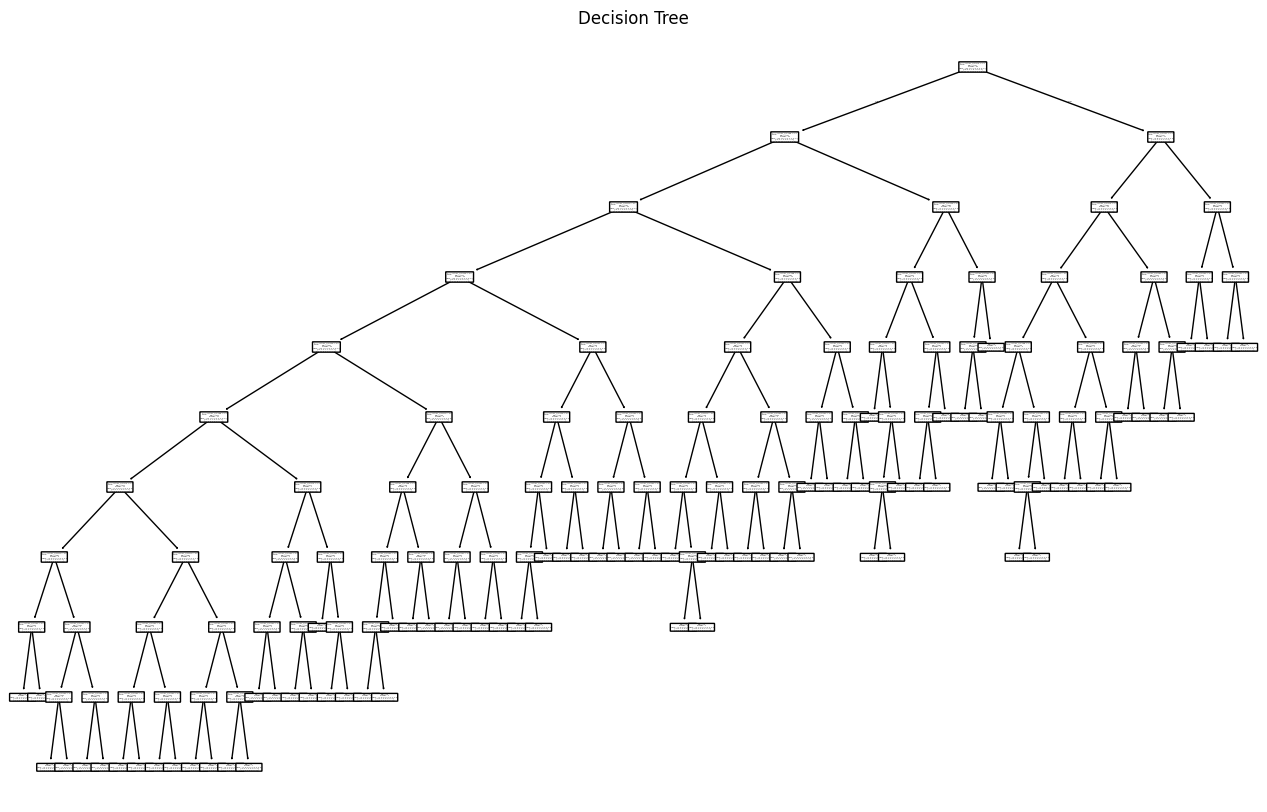

In [23]:

tree_model = pipe.named_steps['model']
fitted_prep = pipe.named_steps['prep']

def get_feature_names_safe(ct: ColumnTransformer) -> list:
    """Return transformed feature names without calling get_feature_names_out
    on SimpleImputer (which would require it to be fitted). For numeric pipeline,
    just return original column names. For categorical pipeline, expand with
    fitted OneHotEncoder names (requires fitted prep).
    """
    names = []
    if not hasattr(ct, 'transformers_'):
        raise RuntimeError("Pipeline is not fitted yet. Please run the training cell first.")
    for name, trans, cols in ct.transformers_:
        if name == 'remainder' and trans == 'drop':
            continue
        if name == 'num':
            # Numeric branch: imputer doesn't change column count; keep originals
            names.extend(list(np.array(cols).astype(str)))
        elif name == 'cat':
            # Categorical branch: need fitted encoder to get expanded names
            if hasattr(trans, 'named_steps'):
                enc = trans.named_steps.get('onehot', None)
                if enc is not None and hasattr(enc, 'get_feature_names_out'):
                    base = np.array(cols).astype(str)
                    expanded = enc.get_feature_names_out(base)
                    names.extend(expanded.tolist())
                else:
                    # Fallback: just use original column names
                    names.extend(list(np.array(cols).astype(str)))
            else:
                names.extend(list(np.array(cols).astype(str)))
        else:
            # Unknown transformer; best effort fallback
            if isinstance(cols, (list, tuple, np.ndarray)):
                names.extend(list(np.array(cols).astype(str)))
    return names

try:
    feature_names = get_feature_names_safe(fitted_prep)
except Exception as e:
    print("Could not derive transformed feature names; falling back to simple indices. Reason:", e)
    feature_names = None  # matplotlib will label as x[0], x[1], ...

plt.figure(figsize=(16, 10))
plot_tree(
    tree_model,
    feature_names=feature_names,
    filled=False,   # do not specify colors
    rounded=True
)
plt.title("Decision Tree")
plt.show()


In [24]:

joblib.dump(pipe, MODEL_PATH)
print(f"Saved trained pipeline to: {MODEL_PATH}")


Saved trained pipeline to: model_decision_tree.joblib


In [25]:

if PREDICT_CSV is not None:
    new_df = pd.read_csv(PREDICT_CSV)
    if TRANSLATE_NON_ASCII_TO_UNICODE:
        obj_cols = new_df.select_dtypes(include=['object']).columns.tolist()
        for col in obj_cols:
            new_df[col] = new_df[col].map(to_unicode_codes)
    missing = [c for c in feature_cols if c not in new_df.columns]
    if missing:
        raise ValueError(f"Prediction CSV is missing required feature columns: {missing}")
    preds = pipe.predict(new_df[feature_cols])
    preds_df = pd.DataFrame(preds, columns=[f"pred_{c}" for c in y.columns])
    out = pd.concat([new_df.reset_index(drop=True), preds_df], axis=1)
    out.to_csv(PREDICTIONS_OUT, index=False)
    print(f"Wrote predictions to: {PREDICTIONS_OUT}")
else:
    print("Set PREDICT_CSV to a CSV path to run batch predictions.")


Set PREDICT_CSV to a CSV path to run batch predictions.


In [26]:

import re
import numpy as np
import pandas as pd

def token_from_char(ch, translate_non_ascii=True):
    """Return either the raw ASCII char or 'U+XXXX' for non-ASCII, depending on setting."""
    if translate_non_ascii and ord(ch) > 127:
        return f'U+{ord(ch):04X}'
    return ch

def decode_unicode_sequence(val):
    """
    Convert a string like 'U+4F60 U+597D' back to characters '你好'.
    If the string does not look like such a sequence, return it unchanged.
    """
    if not isinstance(val, str):
        return val
    parts = val.strip().split()
    # Heuristic: if at least half of tokens look like U+XXXX, treat as code sequence
    def is_code(tok):
        return bool(re.fullmatch(r'U\+[0-9A-Fa-f]{4,6}', tok))
    if not parts or sum(is_code(p) for p in parts) < max(1, len(parts)//2):
        return val
    chars = []
    for tok in parts:
        if is_code(tok):
            cp = int(tok[2:], 16)
            chars.append(chr(cp))
        else:
            # keep literal piece (space-separated) if not a code token
            chars.append(tok)
    return ''.join(chars)

print("Interactive prediction using PREDICTOR columns (press Enter to leave a value blank).")

# Build mapping: predictor index -> predictor column name
pred_idx_name = []
pred_pat = re.compile(r'(?i).*predictors(\d+)$')
for c in predictor_cols:
    m = pred_pat.match(c)
    if m:
        pred_idx_name.append((int(m.group(1)), c))
pred_idx_name.sort(key=lambda x: x[0])

if not pred_idx_name:
    raise RuntimeError("No predictor columns detected. Cannot build predictor-driven input.")

# Build mapping: predictor index -> sorted list of its feature columns (by sub-index j)
feat_groups = {}  # i -> [(j, colname), ...]
feat_pat = re.compile(r'(?i)(.*)feature(\d+)_([0-9]+)$')
for col in feature_cols:
    m = feat_pat.match(col)
    if m:
        i = int(m.group(2))
        j = int(m.group(3))
        feat_groups.setdefault(i, []).append((j, col))
# Sort each group's columns by j
for i in list(feat_groups.keys()):
    feat_groups[i].sort(key=lambda t: t[0])

# Prepare a single-row features dict
row = {col: np.nan for col in feature_cols}

# Ask user for each predictor (in index order)
for i, pred_col in pred_idx_name:
    user_val = input(f"Enter predictor '{pred_col}' (text): ").strip()
    if user_val == '':
        # leave its feature slots as NaN
        continue
    # Convert user string into per-character tokens
    tokens = [token_from_char(ch, translate_non_ascii=TRANSLATE_NON_ASCII_TO_UNICODE) for ch in user_val]
    # Fill into this predictor's feature slots: feature{i}_1, feature{i}_2, ...
    slots = feat_groups.get(i, [])
    if not slots:
        print(f"Warning: No feature slots found for predictor index {i}.")
        continue
    for k, (subidx, colname) in enumerate(slots):
        row[colname] = tokens[k] if k < len(tokens) else np.nan

# Create single-row DataFrame with correct column order
single_X = pd.DataFrame([row], columns=feature_cols)

# Predict
pred = pipe.predict(single_X)

# Print predictions raw and decoded (if applicable)
if pred.ndim == 1:
    raw = pred[0]
    decoded = decode_unicode_sequence(raw) if isinstance(raw, str) else raw
    print("Prediction (raw):", raw)
    if isinstance(raw, str) and decoded != raw:
        print("Prediction (decoded):", decoded)
else:
    for i, col in enumerate(y.columns):
        raw = pred[0, i]
        decoded = decode_unicode_sequence(raw) if isinstance(raw, str) else raw
        print(f"Prediction for target '{col}' (raw):", raw)
        if isinstance(raw, str) and decoded != raw:
            print(f"Prediction for target '{col}' (decoded):", decoded)


Interactive prediction using PREDICTOR columns (press Enter to leave a value blank).


Enter predictor '天干_predictors1' (text):  乙
Enter predictor '日主_predictors2' (text):  甲


Prediction for target '偏正_targets2' (raw): U+6B63
Prediction for target '偏正_targets2' (decoded): 正
Prediction for target '十神_targets3' (raw): U+52AB U+8D22
Prediction for target '十神_targets3' (decoded): 劫财
Prediction for target '相生相克_targets1' (raw): U+540C U+6211
Prediction for target '相生相克_targets1' (decoded): 同我
